## Discretization

- Input: Parameters of the continous RV (e.g.μ,σ), number of discrete elements (N)
- Output: Transition Matrix (P), State Values (Z)

### Methods
- Convert a Normal RV into N-element Markov Chain
- Convert a AR(1) RV into N-element Markov Chain using Tauchen's method
- Convert a AR(1) RV into N-element Markov Chain using Rowenhurst's method



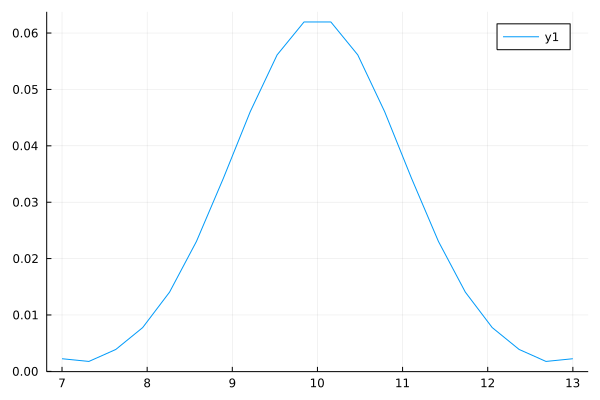

In [1]:
# Discretize a N(μ,σ) into N element Markov Chain
using Distributions

function discreteNormal(μ,σ,N)
    zu = μ + 3*σ
    zl = μ - 3*σ
    Z = collect(range(zl, zu, N))
    M = (Z[1:end-1]+Z[2:end])/2
    z = Normal(μ, σ)
    P1 = [cdf(z, m) for m in M]
    P2 = (P1[2:end]-P1[1:end-1])/2
    P = vcat([cdf(z, M[1])], P2,[1-cdf(z, M[end])])
    return Z, P
end

Z, P = discreteNormal(10,1,20)
using Plots
plot(Z, P)

In [2]:
# Discretize an AR(1) by Tauchen Method
μ,σ,ρ,N = 10,1,0.5,10

function tauchen(μ,σ,ρ,N)
    σ_ = σ/(1-ρ^2)^0.5    
    zu = μ + 3*σ
    zl = μ - 3*σ
    Z = collect(range(zl, zu, N))
    M = (Z[1:end-1]+Z[2:end])/2
    z = Normal(0, 1)
    P = zeros(N,N)
    for i in 2:N-1
        for j in 2:N-1
            P[i,j] = cdf(z, (M[j]-(1-ρ)*μ-ρ*Z[i])/σ)-cdf(z, (M[j-1]-(1-ρ)*μ-ρ*Z[i])/σ)
        end
    end

    P[:,1] = [cdf(z, (M[1]-(1-ρ)*μ-ρ*z_)/σ) for z_ in Z]
    P[:,end] = [(1-cdf(z, (M[end-1]-(1-ρ)*μ-ρ*z_)/σ)) for z_ in Z]
    return Z, P
    end
   
Z, P = tauchen(μ,σ,ρ,N)
P

10×10 Matrix{Float64}:
 0.121673     0.0          0.0         0.0        …  0.0          0.000232629
 0.0668072    0.135521     0.231488    0.257646      0.000707776  0.000770985
 0.0333765    0.088296     0.186865    0.257646      0.00207064   0.00230327
 0.0151301    0.0516771    0.135521    0.231488      0.00543868   0.00620967
 0.00620967   0.0271668    0.088296    0.186865      0.0128269    0.0151301
 0.00230327   0.0128269    0.0516771   0.135521   …  0.0271668    0.0333765
 0.000770985  0.00543868   0.0271668   0.088296      0.0516771    0.0668072
 0.000232629  0.00207064   0.0128269   0.0516771     0.088296     0.121673
 6.32092e-5   0.000707776  0.00543868  0.0271668     0.135521     0.202328
 1.54543e-5   0.0          0.0         0.0           0.0          0.308538

In [3]:
using Distributions, LinearAlgebra

function rowenhorst(mean, uncond_sd, rho, num_states)
    
    # construct grids
    step_r = uncond_sd*sqrt(num_states-1)
    ygrid = -1:2/(num_states-1):1
    ygrid = mean .+ step_r*ygrid
    
    # initialize transition probabilities 
    p = (rho+1)/2
    q = p
    
    transition_matrix = [p 1-p; 1-q q]
    
    # rowenhort's method
    for i = 2:num_states-1
        a1 = [transition_matrix zeros(i, 1); zeros(1, i+1)] 
        a2 = [zeros(i,1) transition_matrix; zeros(1, i+1)]
        a3 = [zeros(1, i+1); transition_matrix zeros(i,1)]
        a4 = [zeros(1, i+1); zeros(i,1) transition_matrix]
        transition_matrix = p*a1 + (1-p)*a2 + (1-q)*a3 + q*a4
        transition_matrix[2:i, :] = transition_matrix[2:i, :]/2
    end
    
    for i = 1:num_states
       transition_matrix[i,:] = transition_matrix[i,:]/sum(transition_matrix[i,:])
    end
    
    # get stationary distribution to normalize effective labour to L=1
    pi = eigvecs(transition_matrix')[:,num_states]
    
    # normalize pi
    pi = pi./sum(pi)
    
    # exponentiate
    ygrid = exp.(ygrid)
    
    # normalize effective labour
    ygrid = ygrid/sum(pi.*ygrid)
    
    return transition_matrix, ygrid
end

rowenhorst (generic function with 1 method)